# Transfer Learning with TensorFlow part 1: Feature Extraction

Two main benefits:
1. Can leverage an existing nn architecture proven to work on problems similar on our own
2. Can leverage already learned patterns and adpot them to our own data

In [60]:
!nvidia-smi

Sat Dec 30 16:28:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              33W /  70W |  12421MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with the data

In [61]:
# Get data (10% of 10 food classes from Food101)

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-30 16:28:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   112MB/s    in 1.4s    

2023-12-30 16:28:25 (112 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [62]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders


In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [64]:
IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32

In [65]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [66]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [67]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               batch_size=BATCH_SIZE)

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               batch_size=BATCH_SIZE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Examples of callbacks:
1. Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard
2. Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
3. Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve.

In [68]:
# Create tensorboard callback (functionized because need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [69]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"

efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b0-feature-vector/versions/1"

In [70]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [71]:
IMAGE_SHAPE

(224, 224)

In [72]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [73]:
# Let's make a create_model() function to create a modle from URL
def create_model(model_url, num_classes=10):
  """
  Takes URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hib feature extraction URL.
    num_classes (int): Number of output neurons.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patters
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


### Creating and testing ResNetv2 model

In [74]:
train_data.num_classes

10

In [75]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            train_data.num_classes)

In [76]:
# Compile
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [77]:
resnet_history = resnet_model.fit(train_data,
                epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231230-162832
Epoch 1/5
24/24 [==============================] - 18s 572ms/step - loss: 2.0961 - accuracy: 0.3200 - val_loss: 1.2512 - val_accuracy: 0.5980
Epoch 2/5
24/24 [==============================] - 11s 465ms/step - loss: 0.9177 - accuracy: 0.7373 - val_loss: 0.8495 - val_accuracy: 0.7232
Epoch 3/5
24/24 [==============================] - 11s 476ms/step - loss: 0.6288 - accuracy: 0.8333 - val_loss: 0.7449 - val_accuracy: 0.7596
Epoch 4/5
24/24 [==============================] - 11s 464ms/step - loss: 0.4718 - accuracy: 0.8787 - val_loss: 0.6835 - val_accuracy: 0.7796
Epoch 5/5
24/24 [==============================] - 13s 544ms/step - loss: 0.3859 - accuracy: 0.9107 - val_loss: 0.6702 - val_accuracy: 0.7800


In [78]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [79]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

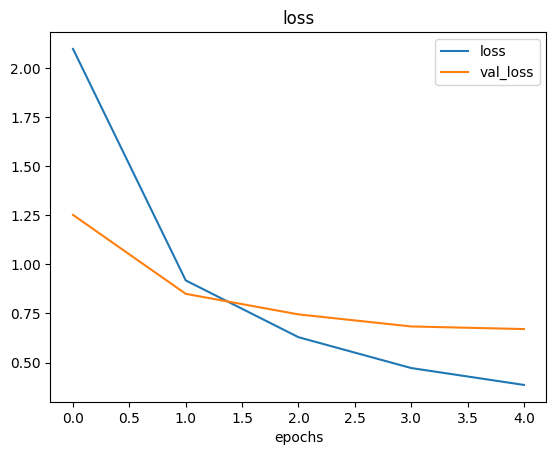

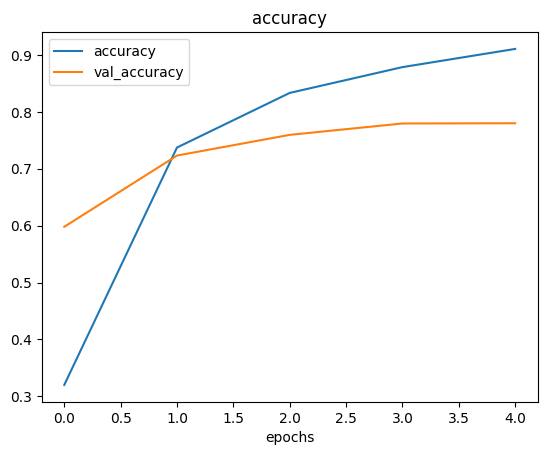

In [80]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetv2 model

In [87]:
efficientnet_model = create_model(efficientnet_url, train_data.num_classes)

In [89]:
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [90]:
efficientnet_history = efficientnet_model.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback("tensorflow_hub",
                                                              "efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20231230-163302
Epoch 1/5
24/24 [==============================] - 21s 519ms/step - loss: 1.8947 - accuracy: 0.4200 - val_loss: 0.7181 - val_accuracy: 0.7660
Epoch 2/5
24/24 [==============================] - 10s 414ms/step - loss: 0.5722 - accuracy: 0.8320 - val_loss: 0.4616 - val_accuracy: 0.8424
Epoch 3/5
24/24 [==============================] - 10s 416ms/step - loss: 0.3676 - accuracy: 0.8960 - val_loss: 0.4009 - val_accuracy: 0.8616
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.2733 - accuracy: 0.9227 - val_loss: 0.3871 - val_accuracy: 0.8724
Epoch 5/5
24/24 [==============================] - 12s 535ms/step - loss: 0.1856 - accuracy: 0.9587 - val_loss: 0.3619 - val_accuracy: 0.8768


In [91]:
efficientnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


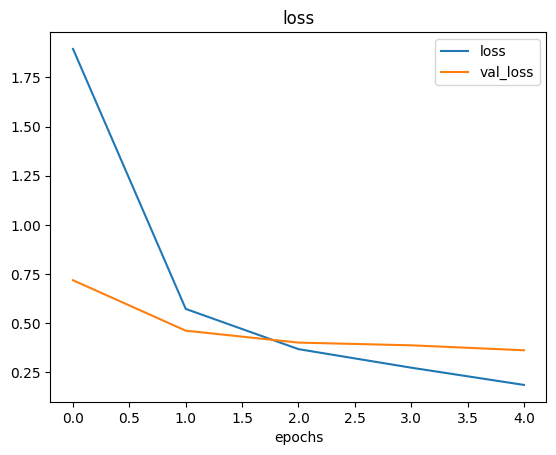

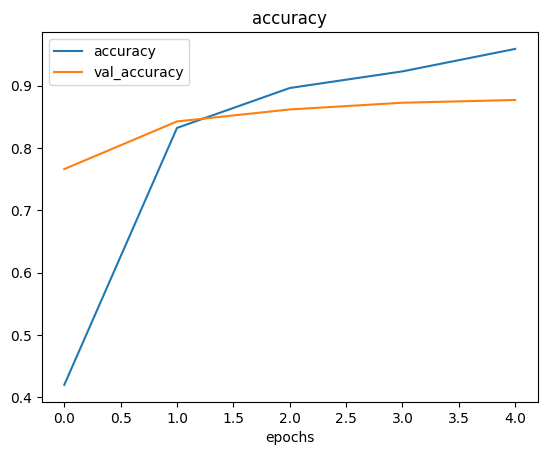

In [92]:
plot_loss_curves(efficientnet_history)

In [93]:
efficientnet_model.layers

In [94]:
efficientnet_model.layers[0].weights

[<tf.Variable 'efficientnetv2-b0/blocks_0/conv2d/kernel:0' shape=(3, 3, 32, 16) dtype=float32, numpy=
 array([[[[-1.00208251e-02, -9.76230726e-02, -1.03572346e-01, ...,
            6.83434010e-02, -9.27658379e-02, -2.81381942e-02],
          [-3.75655033e-02, -5.48017561e-01, -5.66359684e-02, ...,
            2.54087592e-03, -2.32936874e-01,  1.45088192e-02],
          [-2.06300206e-02, -3.94571871e-01, -1.17480762e-01, ...,
            1.68354958e-02,  1.37243807e-01, -3.75802398e-01],
          ...,
          [-1.77918840e-02,  3.42421502e-01, -2.45684549e-01, ...,
           -3.04920366e-03, -1.57090388e-02,  2.82508194e-01],
          [ 3.89756076e-02, -1.04206055e-01, -1.61297441e-01, ...,
           -8.64439905e-02, -2.24101961e-01, -8.35027695e-02],
          [ 8.84641334e-02, -2.60541350e-01,  1.44419834e-01, ...,
           -2.67723858e-01,  1.89969540e-01, -2.66337305e-01]],
 
         [[-5.80069236e-02,  1.94894262e-02,  9.41956639e-02, ...,
           -8.78865793e-02,  7.14

Different types of transfer learning:
- **Original model**
  - same dataset and all parameteres
- **Feature extraction**
  - different dataset and output layer
  - same parameters in hidden layers
- **Fine-tuning** (needs more data than fe)
  - different dataset, hidden and output layers

## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public!!!

In [95]:
# Upload TensorBoard dev records
! tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2023-12-30 16:59:31.026538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 16:59:31.026606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 16:59:31.027932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 16:59:32.349701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb